In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import Sequential, Model, optimizers
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, SimpleRNN, Bidirectional
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Import Data

In [2]:
dataset = pd.read_csv('data_nomean.csv', index_col=0)
dataset.tail()

,index,middle,ring,pinky,label
159995,"[0.20588235294117624, 0.20588235294117624, 0.2...","[0.902254409463127, 0.902254409463127, 0.90208...","[0.9900052169121742, 0.9900052169121742, 0.990...","[0.9963689704020832, 0.9963689704020832, 0.996...",4-4
159996,"[0.20517241379310305, 0.20517241379310305, 0.2...","[0.9019139943862396, 0.9019139943862396, 0.901...","[0.9896662412047679, 0.9896662412047679, 0.989...","[0.99636890657134, 0.99636890657134, 0.9963689...",4-4
159997,"[0.20309810671256565, 0.20309810671256565, 0.2...","[0.9015749535299048, 0.9015749535299048, 0.901...","[0.9893274045996283, 0.9893274045996283, 0.989...","[0.9963688975135385, 0.9963688975135385, 0.996...",4-4
159998,"[0.2013651877133101, 0.20307167235494875, 0.20...","[0.9007786395940026, 0.9007786395940026, 0.900...","[0.9884862585194406, 0.9886555782470959, 0.988...","[0.996368908937689, 0.996368908937689, 0.99636...",4-4
159999,"[0.2033898305084746, 0.2033898305084746, 0.205...","[0.9001348366181828, 0.9003040996069657, 0.900...","[0.9881515907852081, 0.9881515907852081, 0.988...","[0.9960072349640712, 0.9960072349640712, 0.996...",4-4


# Data Processing

In [3]:
## X
n_steps = len(json.loads(dataset.iloc[0,0]))
n_features = 4
X = np.empty((dataset.shape[0], n_steps*n_features), dtype=np.float64)
for i in range(X.shape[0]):    
    x = []
    for j in range(n_features):
        arr = list(json.loads(dataset.iloc[i,j]))
        x += arr
    X[i] = np.array(x)

## y
labels = dataset["label"].to_numpy()
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
n_classes = len(np.unique(y_encoded))
y = to_categorical(y_encoded)

# print(X.shape)

X = X.reshape((160000,30,4))

## split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape)

(78400, 30, 4) (78400, 25)


# Model Training

In [4]:
# define model
inputs = Input(shape=(30,4))
x = inputs
x = BatchNormalization()(x)
x = Conv1D(16,5,strides=1,activation='relu')(inputs)
x = Conv1D(32,5,strides=1,activation='relu')(x)
x = Conv1D(64,3,strides=1,activation='relu')(x)
x = Conv1D(128,3,strides=1,activation='relu')(x)
x = Bidirectional(SimpleRNN(128))(x)
x = Flatten()(x)
x = Dense(64,'relu')(x)
x = Dropout(0.2)(x)
x = Dense(32,'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(25,'softmax')(x)
model = Model(inputs,outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 4)]           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 16)            336       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 128)           24704     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              65792     
 l)                                                              
                                                             

In [5]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy","accuracy"],
)

In [6]:
n_epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=128)

Epoch 1/10


2023-03-23 10:28:07.986157: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


613/613 [==============================] - 18s 28ms/step - loss: 2.4623 - categorical_accuracy: 0.2650 - accuracy: 0.2650 - val_loss: 1.6120 - val_categorical_accuracy: 0.4936 - val_accuracy: 0.4936
Epoch 2/10
613/613 [==============================] - 18s 30ms/step - loss: 1.5780 - categorical_accuracy: 0.4892 - accuracy: 0.4892 - val_loss: 1.0356 - val_categorical_accuracy: 0.6924 - val_accuracy: 0.6924
Epoch 3/10
613/613 [==============================] - 19s 32ms/step - loss: 1.2461 - categorical_accuracy: 0.5878 - accuracy: 0.5878 - val_loss: 0.8311 - val_categorical_accuracy: 0.7419 - val_accuracy: 0.7419
Epoch 4/10
613/613 [==============================] - 19s 31ms/step - loss: 1.0337 - categorical_accuracy: 0.6573 - accuracy: 0.6573 - val_loss: 0.6451 - val_categorical_accuracy: 0.8096 - val_accuracy: 0.8096
Epoch 5/10
613/613 [==============================] - 19s 32ms/step - loss: 0.8897 - categorical_accuracy: 0.7073 - accuracy: 0.7073 - val_loss: 0.5784 - val_categorical_a

# Model Evaluation

Train accuracy: 0.825382649898529
Validation accuracy: 0.882232129573822
Test accuracy: 0.8824583292007446


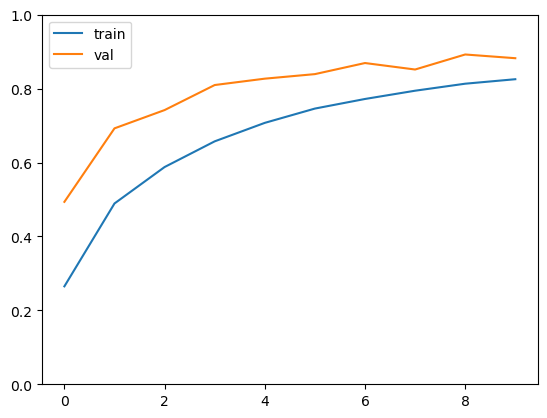

In [8]:
print("Train accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])
print("Test accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.ylim((0,1))
plt.show()

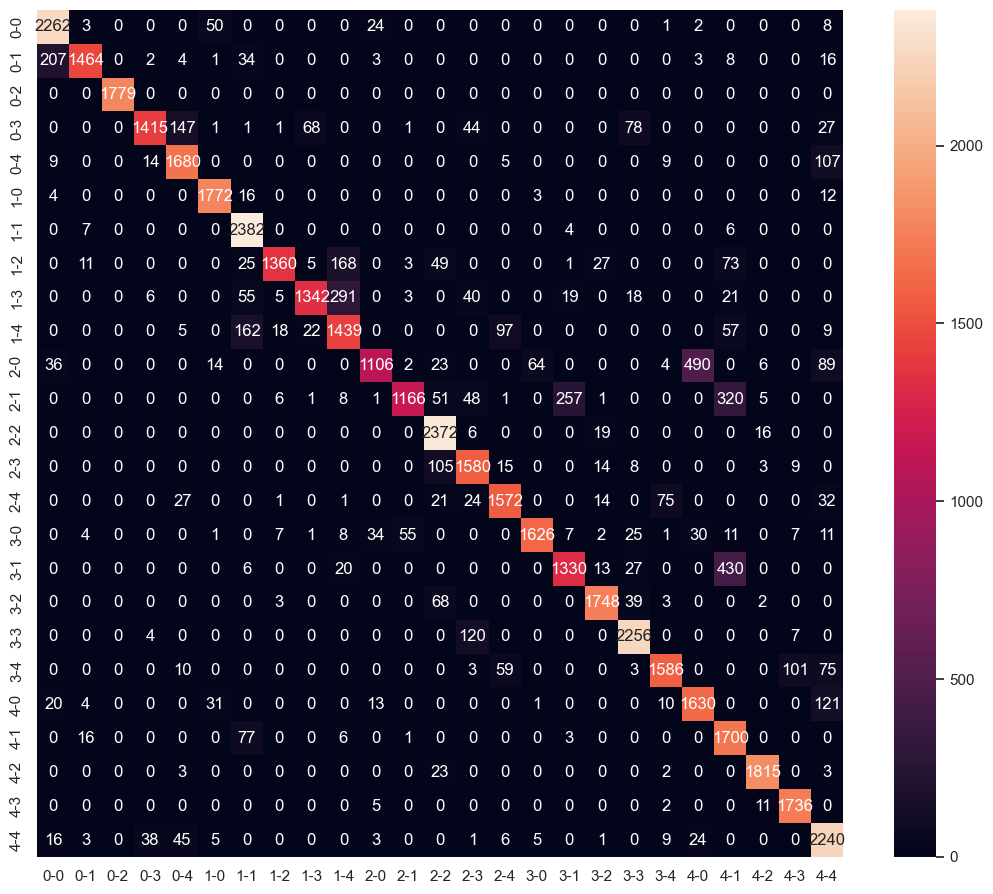

In [9]:
y_pred = model.predict(x_test, verbose=0)
y_pred_rd = np.argmax(y_pred, axis=1)
y_test_rd = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_rd, y_pred_rd)
# plt.figure(figsize=(40,40))
# plt.matshow(cm)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
plt.figure(figsize=(13,11))
sn.set(font_scale=1) # for label size
ticklabels = np.unique(labels)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="d",
           xticklabels=ticklabels, yticklabels=ticklabels) # font size
plt.show()

In [14]:
import time 
times = []
for i in range(100):
    start = time.time()
    y_prediction = model.predict(x_test, verbose=0) 
    end = time.time()
    times.append((end - start)/x_test.shape[0] * 1000)
print("Inference time: %f ms" % (np.mean(np.array(times))))

KeyboardInterrupt: 

In [12]:
model.save('./save_model/rnn')

INFO:tensorflow:Assets written to: ./save_model/rnn/assets


INFO:tensorflow:Assets written to: ./save_model/rnn/assets


In [13]:
import joblib

joblib.dump(le, './save_model/label_encoder.joblib')

['./save_model/label_encoder.joblib']